In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.tree import export_graphviz
from IPython.display import Image

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [75]:
cc = pd.read_csv('data/final_data.csv')

In [76]:
cc = cc.iloc[:,1:]
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   seniorcitizen                            7043 non-null   int64  
 1   tenure                                   7043 non-null   int64  
 2   monthlycharges                           7043 non-null   float64
 3   totalcharges                             7043 non-null   float64
 4   churn                                    7043 non-null   int64  
 5   gender_Female                            7043 non-null   int64  
 6   gender_Male                              7043 non-null   int64  
 7   partner_No                               7043 non-null   int64  
 8   partner_Yes                              7043 non-null   int64  
 9   dependents_No                            7043 non-null   int64  
 10  dependents_Yes                           7043 no

In [77]:
y = cc.churn
X = cc.drop('churn',axis=1)


In [78]:
mm = MinMaxScaler()
scaled_cc= pd.DataFrame(mm.fit_transform(X),columns=X.columns)
scaled_cc.head(2)

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0.0,0.013889,0.115423,0.003437,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.217564,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [79]:
# split train-test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25,random_state=35)

## Decision Tree Classifier

In [80]:
dt = DecisionTreeClassifier(random_state=35)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=35)

In [81]:
test_pred1 = dt.predict(X_test)

In [82]:
# calculate 4 metrics
print(f"Precision: {precision_score(y_test, test_pred1)}")
print(f"Recall: {recall_score(y_test, test_pred1)}")
print(f"Accuracy: {accuracy_score(y_test, test_pred1)}")
print(f"F1: {f1_score(y_test, test_pred1)}")

Precision: 0.4879120879120879
Recall: 0.49443207126948774
Accuracy: 0.7387847813742192
F1: 0.49115044247787615


In [94]:
# assign false positive, true positive, threshold
fpr,tpr,threshold = roc_curve(y_test,test_pred1)

In [84]:
#calculate auc score
auc_score = auc(fpr,tpr)

In [85]:
#print auc score
print(f'AUC Score: {auc_score}')

AUC Score: 0.6584203039274268


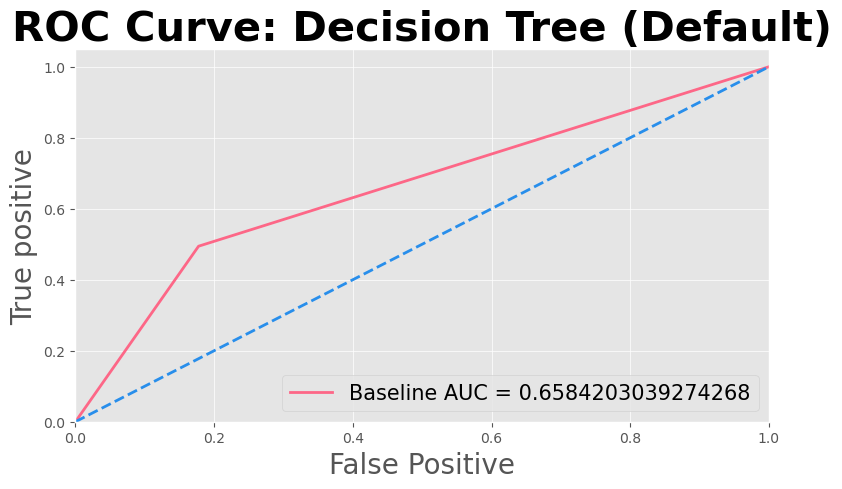

In [95]:
# plot auc curve
plt.figure(figsize=(8,5))
plt.grid(linewidth= .5)
plt.plot(fpr,tpr,color='#FD6787',lw =2, label = 'Baseline AUC = '+str(auc_score))
plt.plot([0,1],[0,1], linestyle = '--', lw = 2,color='#288EEB')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive', fontsize = 20)
plt.ylabel('True positive', fontsize = 20)
plt.title('ROC Curve: Decision Tree (Default)', fontsize = 30,fontweight = 'bold')
plt.legend(loc=4, fontsize= 15)
plt.tight_layout()

In [87]:
pd.crosstab(y_test,test_pred1,rownames=['True'],colnames = ['Predicted'],margins=True) 

Predicted,0,1,All
True,,,
0,1079,233,1312
1,227,222,449
All,1306,455,1761


## GridSearchCV 

In [88]:
gscv = DecisionTreeClassifier(random_state = 33)
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'min_samples_split':[20, 25, 30, 35, 40],
    'min_samples_leaf':[1,2,3,4,5,6]
}
gscv_tree = GridSearchCV(gscv, param_grid, cv = 4, verbose = True)
gscv_tree.fit(X_train, y_train)

Fitting 4 folds for each of 720 candidates, totalling 2880 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=33),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
                                       20],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [20, 25, 30, 35, 40]},
             verbose=True)

In [89]:
print(f'Best parameter: {gscv_tree.best_params_}')
print(f'\nBest Score: {gscv_tree.best_score_}')

Best parameter: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 20}

Best Score: 0.7892839733443442


## GridSearchCV Decision Tree

In [90]:
final_tree = DecisionTreeClassifier(criterion='gini',
                                    max_depth=5,
                                    min_samples_leaf=6,
                                    min_samples_split = 20,
                                    random_state=35)
final_tree.fit(X_train,y_train)
test_pred_final = final_tree.predict(X_test)

In [91]:
# calculate 4 metrics
print(f"Precision: {precision_score(y_test, test_pred_final)}")
print(f"Recall: {recall_score(y_test, test_pred_final)}")
print(f"Accuracy: {accuracy_score(y_test, test_pred_final)}")
print(f"F1: {f1_score(y_test, test_pred_final)}")


Precision: 0.6450617283950617
Recall: 0.46547884187082406
Accuracy: 0.7984099943214082
F1: 0.5407503234152652


AUC Score: 0.6889132014232169


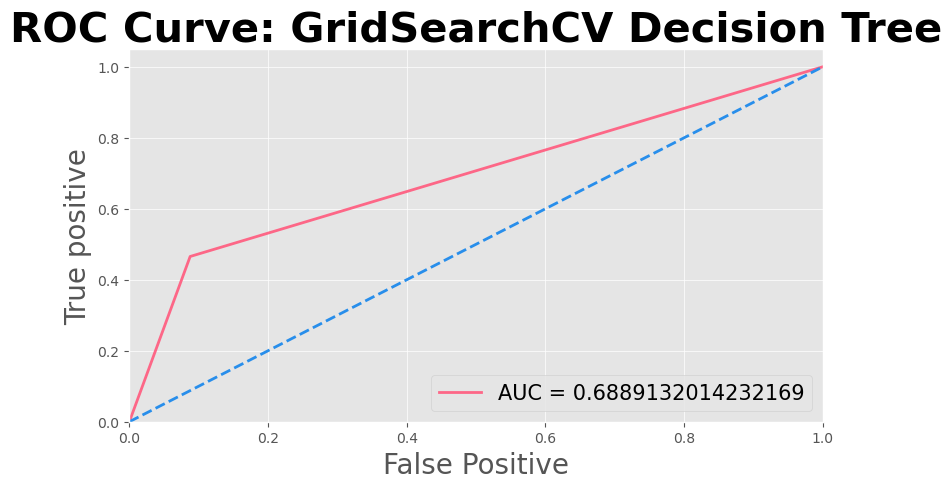

In [92]:
fpr_final, tpr_final, threshold_final = roc_curve(y_test, test_pred_final)
auc_score_final = auc(fpr_final, tpr_final)
print(f'AUC Score: {auc_score_final}')
# plot auc curve
plt.figure(figsize=(8,5))
plt.grid(linewidth= .5)
plt.plot(fpr_final,tpr_final,color='#FD6787',lw =2, label = 'AUC = '+str(auc_score_final))
plt.plot([0,1],[0,1], linestyle = '--', lw = 2,color='#288EEB')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive', fontsize = 20)
plt.ylabel('True positive', fontsize = 20)
plt.title('ROC Curve: GridSearchCV Decision Tree', fontsize = 30,fontweight = 'bold')
plt.legend(loc=4, fontsize= 15)
plt.tight_layout()


In [93]:
pd.crosstab(y_test,test_pred_final,rownames=['True'],colnames=['Predicted'],margins=True)

Predicted,0,1,All
True,,,
0,1197,115,1312
1,240,209,449
All,1437,324,1761
